# <span style="color:blue"> Monoasset test: Pricing European Option </span>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pricing import DiscountingCurve, EquityForwardCurve, Black,ForwardVariance,Vanilla_PayOff
from montecarlo import MC,MC_Analisys
import lets_be_rational.LetsBeRational as lbr
from closedforms import d1, European_option_closed_form, Delta, StrikeFromDelta
import scipy.stats as si
import time, sys
from scipy import log, sqrt, exp
import matplotlib.ticker as mticker

### Parameters of Simulation

In [2]:
r = 1/100
t = 0
volatility = 20/100
spot_price = 150
T_max = 10.
N_simulations = 1e6

### Market Data

In [3]:
"""Discounut Factors"""
zero_interest_rate = np.array([r,r,r])
zero_interest_rate_dates = np.array([0.01,5,T_max])
d = exp(-zero_interest_rate*zero_interest_rate_dates)        #market discount factors 
D = DiscountingCurve(reference=t, discounts=d, dates=zero_interest_rate_dates)   #discounting curve
F = EquityForwardCurve(reference=t, discounting_curve=D, spot=spot_price,repo_dates=np.array([0.1,T_max]), repo_rates=np.array([0.,0.]))

Forward interest rate time grid [ 0.01  5.   10.  ]
Forward interest rate:  [0.01 0.01 0.01]
Forward repo time grid [ 0.1 10. ]
Forward repo rate:  [0. 0.]


In [4]:
K_spot_vola = np.array([spot_price,200])
spot_vol = np.array(([volatility,volatility],[0.3,0.3]))
spot_vol_dates = np.array([0.1,T_max])
V = ForwardVariance(reference=t,maturities=spot_vol_dates,strikes=K_spot_vola,spot_volatility=spot_vol,strike_interp=spot_price)

Forward volatility time grid:  [ 0.1 10. ]
Forward volatility:  [0.2 0.2]



### Simulation

In [11]:
kind = 1
B_model = Black(variance=V, forward_curve=F)
maturities = np.arange(1,31)*0.15
S_t = B_model.simulate(fixings=maturities, Nsim=N_simulations, seed=12)
K = spot_price
price_call = Vanilla_PayOff(St=S_t, strike = K, typo = kind)

"""Calculating closed form"""
call_black = European_option_closed_form(forward=F(maturities), strike=K, maturity=maturities, reference=t, volatility=volatility, zero_interest_rate=r, typo = kind)

Single Asset Simulation


### Convergence Check

In [12]:
x, mean, err = MC_Analisys(price_call,100)

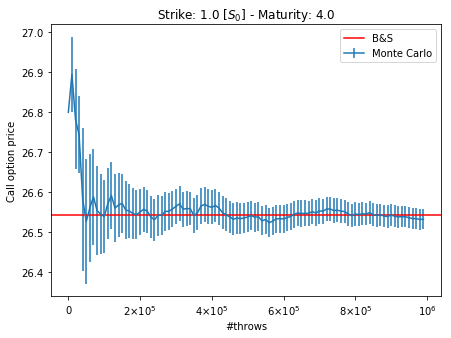

In [13]:
n = 26

mean_price = (mean*D(maturities)).T[n]
err_price = (err*D(maturities)).T[n]

plt.figure(figsize=(7,5))
plt.errorbar(x,mean_price,yerr=err_price,label = 'Monte Carlo')
plt.axhline(y=call_black[n], color = 'red',linestyle='-',label = 'B&S')
plt.xlabel("#throws")
plt.title("Strike: "+str(K/spot_price)+" [$S_0$] - Maturity: "+str(round(maturities[n],1)))
f = mticker.ScalarFormatter(useOffset=False, useMathText=True)
g = lambda x,pos : "${}$".format(f._formatSciNotation('%1.10e' % x))
plt.gca().xaxis.set_major_formatter(mticker.FuncFormatter(g))
plt.legend()
if kind==1:
    plt.ylabel('Call option price')
    #plt.savefig('Graphs/European_call_option.pdf')
elif kind==-1:
    plt.ylabel('Put option price')
    #plt.savefig('Graphs/European_put_option.pdf')
plt.show()

/home/ste/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


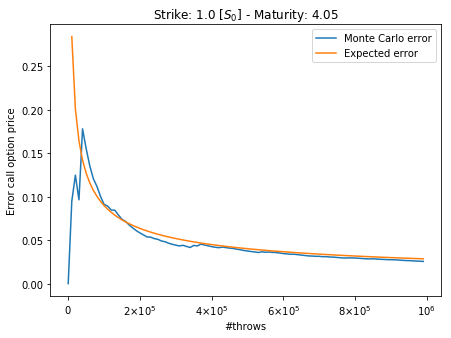

In [14]:
z = np.std(price_call.T[n])
y = np.sqrt(x)
plt.figure(figsize=(7,5))
plt.plot(x,err_price, label = 'Monte Carlo error')
plt.plot(x,z/y, label = 'Expected error')
plt.xlabel("#throws")
plt.title("Strike: "+str(K/spot_price)+" [$S_0$] - Maturity: "+str(round(maturities[n],2)))
f = mticker.ScalarFormatter(useOffset=False, useMathText=True)
g = lambda x,pos : "${}$".format(f._formatSciNotation('%1.10e' % x))
plt.gca().xaxis.set_major_formatter(mticker.FuncFormatter(g))
plt.legend()
if kind==1:
    plt.ylabel('Error call option price')
   # plt.savefig('Graphs/Error_euro_call_option.pdf')
elif kind==-1:
    plt.ylabel('Error put option price')
    #plt.savefig('Graphs/Error_euro_put_option.pdf')

plt.show()

### Implied volatility in function of log Moneyness log(K/F)

In [9]:
kind = -1
logmoneyness =np.arange(-10,11)*0.1
imp_volatility = np.zeros((len(logmoneyness),len(maturities)))
imp_volatility_plus = np.zeros((len(logmoneyness),len(maturities)))
imp_volatility_minus = np.zeros((len(logmoneyness),len(maturities)))
X_t = S_t/F(maturities)
E_X = np.mean(X_t,axis=0)
start_time = time.time()
for i in range(len(logmoneyness)):
    if i%10 == 0:
        print("Running: ",i,"%")
    if logmoneyness[i]>=0.:
        kind =1
    elif logmoneyness[i]<0.:
        kind =-1
    K = np.exp(logmoneyness[i])
    option = Vanilla_PayOff(St=X_t, strike=K,typo=kind)
    result, err_result = MC(option)
    for j in range(len(maturities)):
        imp_volatility[i][j] = lbr.implied_volatility_from_a_transformed_rational_guess(result[j],E_X[j],K,maturities[j],kind)
        imp_volatility_plus[i][j] = lbr.implied_volatility_from_a_transformed_rational_guess(result[j]+err_result[j],E_X[j],K,maturities[j],kind)
        imp_volatility_minus[i][j] = lbr.implied_volatility_from_a_transformed_rational_guess(result[j]-err_result[j],E_X[j],K,maturities[j],kind)
        
print("Execution time: ---%s min ---" %((time.time()-start_time)/60))
print("Saving_Files...")
#np.savetxt("Results_moneyness_forward/norm_implied_volatility_mean_log.txt",imp_volatility)    #saving results
#np.savetxt("Results_moneyness_forward/norm_implied_volatility_minus_log.txt",imp_volatility_minus)    #saving results
#np.savetxt("Results_moneyness_forward/norm_implied_volatility_plus_log.txt",imp_volatility_plus)    #saving results
#np.savetxt("Results_moneyness_forward/norm_moneyness_log.txt",logmoneyness)
#np.savetxt("Results_moneyness_forward/norm_maturities_log.txt",maturities)
print("COMPLETED")

Running:  0 %
Running:  10 %
Running:  20 %
Execution time: ---1.8483759959538777 min ---
Saving_Files...
COMPLETED


logmoneyness = np.loadtxt("Results_moneyness_forward/norm_moneyness_log.txt")
maturities = np.loadtxt("Results_moneyness_forward/norm_maturities_log.txt")
imp_volatility = np.loadtxt("Results_moneyness_forward/norm_implied_volatility_mean_log.txt")
imp_volatility_plus = np.loadtxt("Results_moneyness_forward/norm_implied_volatility_plus_log.txt")
imp_volatility_minus = np.loadtxt("Results_moneyness_forward/norm_implied_volatility_minus_log.txt")

In [10]:
y_lower = np.zeros((len(logmoneyness),len(maturities)))
y_upper = np.zeros((len(logmoneyness),len(maturities)))
for i in range(len(logmoneyness)):
     for j in range(len(maturities)):
            if(imp_volatility_minus[i][j]<imp_volatility_plus[i][j]):
                y_lower[i][j] = abs(imp_volatility[i][j]-imp_volatility_minus[i][j])
                y_upper[i][j] = abs(imp_volatility_plus[i][j]-imp_volatility[i][j])
            elif(imp_volatility_minus[i][j]>imp_volatility_plus[i][j]):
                y_lower[i][j] = abs(imp_volatility[i][j]-imp_volatility_plus[i][j])
                y_upper[i][j] = abs(imp_volatility_minus[i][j]-imp_volatility[i][j])


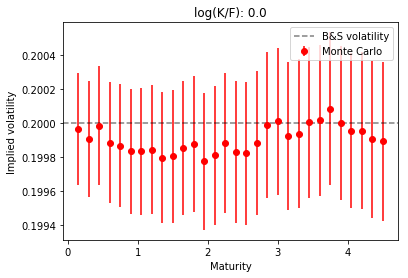

In [12]:
"""Fixed Strike"""  #ATM = 5
num = [10]    # 0, 5, 15
c=2
for i in range(len(num)):
    err_lower = 2*y_lower[num[i]]
    err_upper = 2*y_upper[num[i]]
    plt.errorbar(maturities,imp_volatility[num[i]],yerr=[err_lower,err_upper],fmt="o",color = "red",label="Monte Carlo")
    plt.title("log(K/F): "+str(round(logmoneyness[num[i]],c)))

plt.axhline(y=volatility, color = 'black',alpha = 0.5,linestyle='--',label = 'B&S volatility')
plt.xlabel("Maturity")
plt.ylabel("Implied volatility")
plt.legend()
#plt.savefig("Graphs/implied_vol_logmoney"+str(round(logmoneyness[num[i]],c))+".pdf")
plt.show()

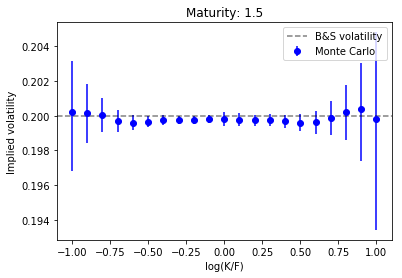

In [13]:
"""Fixed Maturity"""
num = [9]  #0, 6, 39
c=1
for i in range(len(num)):
    err_lower = 2*y_lower.T[num[i]]
    err_upper = 2*y_upper.T[num[i]]
    plt.errorbar(logmoneyness,imp_volatility.T[num[i]],yerr=[err_lower,err_upper],fmt="o",color="blue",label="Monte Carlo")
plt.axhline(y=volatility, color = 'black',alpha = 0.5,linestyle='--',label = 'B&S volatility')  
plt.xlabel("log(K/F)")
plt.ylabel("Implied volatility")
plt.title("Maturity: "+str(round(maturities[num[i]],c)))
plt.legend()
#plt.savefig("Graphs/implied_vol_logmaturity"+str(round(maturities[num[i]],c))+".pdf")
plt.show()

### Results in term of Delta

In [20]:
kind = -1
delta = np.arange(2,21)*0.05
imp_volatility = np.zeros((len(delta),len(maturities)))
imp_volatility_plus = np.zeros((len(delta),len(maturities)))
imp_volatility_minus = np.zeros((len(delta),len(maturities)))
X_t = S_t/F(maturities)
E_X = np.mean(X_t,axis=0)
start_time = time.time()
for j in range(len(maturities)):
    if j%10 == 0:
        print("Running: ",j,"%")
    for i in range(len(delta)):
        K = StrikeFromDelta(F,maturities[j],delta[i],sigma)
        if K >= F(maturities[j]):
            kind = 1  #1 buono
           # print("Sono una call")
        elif K<F(maturities[j]):
            kind = -1  #-1 buono
          #  print("Sono una put")
        option = Vanilla_PayOff(St=X_t, strike=K/F(maturities),typo=kind)
        result, err_result = MC(option)
        imp_volatility[i][j] = lbr.implied_volatility_from_a_transformed_rational_guess(result[j],E_X[j],K/F(maturities[j]),maturities[j],kind)
        imp_volatility_plus[i][j] = lbr.implied_volatility_from_a_transformed_rational_guess(result[j]+err_result[j],E_X[j],K/F(maturities[j]),maturities[j],kind)
        imp_volatility_minus[i][j] = lbr.implied_volatility_from_a_transformed_rational_guess(result[j]-err_result[j],E_X[j],K/F(maturities[j]),maturities[j],kind)

    
print("Execution time: ---%s min ---" %((time.time()-start_time)/60))
print("Saving_Files...")
#np.savetxt("Results_moneyness_forward/norm_implied_volatility_mean_delta.txt",imp_volatility)    #saving results
#np.savetxt("Results_moneyness_forward/norm_implied_volatility_minus_delta.txt",imp_volatility_minus)    #saving results
#np.savetxt("Results_moneyness_forward/norm_implied_volatility_plus_delta.txt",imp_volatility_plus)    #saving results
#np.savetxt("Results_moneyness_forward/norm_moneyness_delta.txt",delta)
#np.savetxt("Results_moneyness_forward/norm_maturities_delta.txt",maturities)
print("COMPLETED")

Running:  0 %
Running:  10 %
Running:  20 %
Execution time: ---25.401083906491596 min ---
Saving_Files...
COMPLETED


delta = np.loadtxt("Results_moneyness_forward/norm_moneyness_delta.txt")
maturities = np.loadtxt("Results_moneyness_forward/norm_maturities_delta.txt")
imp_volatility = np.loadtxt("Results_moneyness_forward/norm_implied_volatility_mean_delta.txt")
imp_volatility_plus = np.loadtxt("Results_moneyness_forward/norm_implied_volatility_plus_delta.txt")
imp_volatility_minus = np.loadtxt("Results_moneyness_forward/norm_implied_volatility_minus_delta.txt")

In [22]:
y_lower = np.zeros((len(delta),len(maturities)))
y_upper = np.zeros((len(delta),len(maturities)))
for i in range(len(delta)):
     for j in range(len(maturities)):
            if(imp_volatility_minus[i][j]<imp_volatility_plus[i][j]):
                y_lower[i][j] = abs(imp_volatility[i][j]-imp_volatility_minus[i][j])
                y_upper[i][j] = abs(imp_volatility_plus[i][j]-imp_volatility[i][j])
            elif(imp_volatility_minus[i][j]>imp_volatility_plus[i][j]):
                y_lower[i][j] = abs(imp_volatility[i][j]-imp_volatility_plus[i][j])
                y_upper[i][j] = abs(imp_volatility_minus[i][j]-imp_volatility[i][j])
            if abs(imp_volatility[i][j])>100:
                imp_volatility[i][j] = None
          

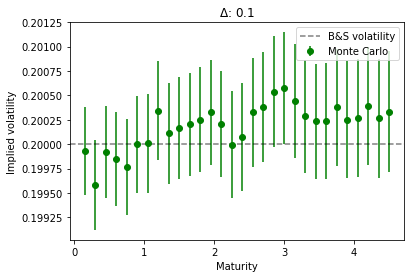

In [29]:
"""Fixed Strike"""  #ATM = 5
num = [0]
c=2
for i in range(len(num)):
    err_lower = 2*y_lower[num[i]]
    err_upper = 2*y_upper[num[i]]
    plt.errorbar(maturities,imp_volatility[num[i]],yerr=[err_lower,err_upper],fmt="o",color = "green",label="Monte Carlo")
    plt.title("$\Delta$: "+str(round(delta[num[i]],c)))

plt.axhline(y=volatility, color = 'black',alpha = 0.5,linestyle='--',label = 'B&S volatility')
plt.xlabel("Maturity")
plt.ylabel("Implied volatility")
plt.legend()
plt.savefig("Graphs/implied_vol_delta"+str(round(delta[num[i]],c))+".pdf")
plt.show()

[0.0006188  0.00057951 0.00056296 0.00055794 0.00056025 0.00056791
 0.00058011 0.00059654 0.00061723 0.00064258 0.00025392 0.00027554
 0.00029012 0.00029831 0.00030332 0.00030772 0.0003149  0.00033569
 0.        ]


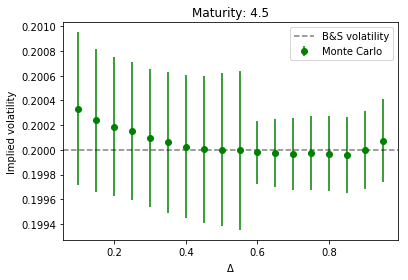

In [27]:
"""Fixed Maturity"""
num = [29]  #0, 6, 39
c=1
for i in range(len(num)):
    err_lower = 2*y_lower.T[num[i]]
    err_upper = 2*y_upper.T[num[i]]
    plt.errorbar(delta,imp_volatility.T[num[i]],yerr=[err_lower,err_upper],fmt="o",color="green",label="Monte Carlo")
plt.axhline(y=volatility, color = 'black',alpha = 0.5,linestyle='--',label = 'B&S volatility')  
plt.xlabel("$\Delta$")
plt.ylabel("Implied volatility")
plt.title("Maturity: "+str(round(maturities[num[i]],c)))
plt.legend()
#plt.savefig("Graphs/implied_vol_deltamaturity"+str(round(maturities[num[i]],c))+".pdf")
plt.show()

### Test asimmetria dell'errore tra call e put ad ATM

In [15]:
kind =1
ATM = 10
S_t = B_model.simulate(fixings=maturities,Nsim=N_simulations, seed=9)
print("Il Forward è ",F(maturities))
logmoneyness =np.arange(-10,11)*0.1
K1 =F(maturities)* np.exp(logmoneyness[ATM])
print("Strike per call:",K1)
option1 = Vanilla_PayOff(St=S_t, strike=K1,typo=kind)*D(maturities)  #call
x1,r1,e1 = MC_Analisys(option1,100)
kind =-1
K1 =F(maturities)* np.exp(logmoneyness[ATM])
print("Strike per put:",K1)
option2 = Vanilla_PayOff(St=S_t, strike=K1,typo=kind)*D(maturities)  #put
x2,r2,e2 = MC_Analisys(option2,100)

Single Asset Simulation
Il Forward è  [150.22516883 150.45067568 150.67652103 150.90270541 151.12922932
 151.35609327 151.58329777 151.81084333 152.03873047 152.26695969
 152.49553152 152.72444646 152.95370503 153.18330775 153.41325512
 153.64354768 153.87418594 154.10517041 154.33650163 154.56818009
 154.80020634 155.03258089 155.26530426 155.49837697 155.73179956
 155.96557255 156.19969646 156.43417181 156.66899915 156.90417899]
Strike per call: [150.22516883 150.45067568 150.67652103 150.90270541 151.12922932
 151.35609327 151.58329777 151.81084333 152.03873047 152.26695969
 152.49553152 152.72444646 152.95370503 153.18330775 153.41325512
 153.64354768 153.87418594 154.10517041 154.33650163 154.56818009
 154.80020634 155.03258089 155.26530426 155.49837697 155.73179956
 155.96557255 156.19969646 156.43417181 156.66899915 156.90417899]
Strike per put: [150.22516883 150.45067568 150.67652103 150.90270541 151.12922932
 151.35609327 151.58329777 151.81084333 152.03873047 152.26695969
 15

In [16]:
counter = 0
for i in range(len(maturities)):
    for j in range(len(option1)):
        if option1[j,i] ==0:
            counter = counter+1
            
print("Numero di zeri per la call",counter)

Numero di zeri per la call 3455380


In [17]:
counter2 = 0
for i in range(len(maturities)):
    for j in range(len(option2)):
        if option2[j,i] ==0:
            counter2 = counter2+1
            
print("Numero di zeri per la put",counter2)
if counter2>counter:
    print("La put presenta più zeri nel payoff")
else:
    print("La call presenta più zeri nel payoff")

Numero di zeri per la put 0
La call presenta più zeri nel payoff


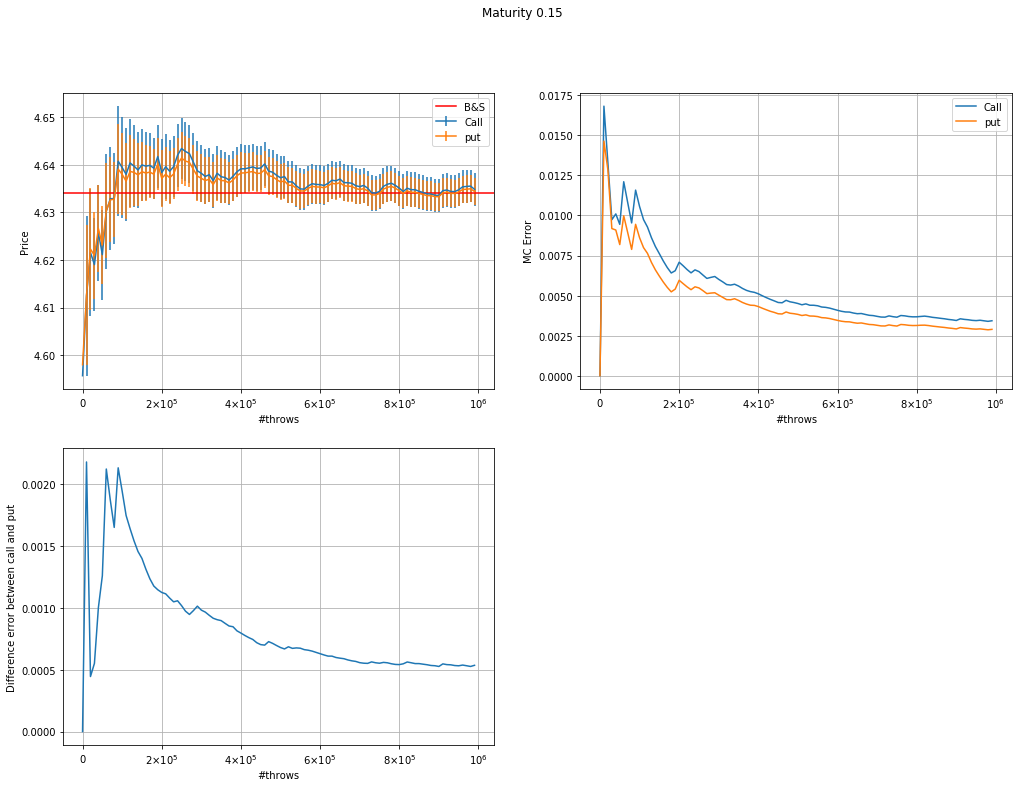

In [32]:
n = 0
plt.figure(figsize=(17,12))
plt.suptitle("Maturity "+str(round(maturities[n],2)))
call_black = European_option_closed_form(forward=F(maturities), strike=K1[n], maturity=maturities, reference=t, volatility=volatility, zero_interest_rate=r, typo = kind)
plt.subplot(2,2,1)
plt.errorbar(x1,r1.T[n],yerr=e1.T[n],label="Call")
plt.errorbar(x2,r2.T[n],yerr=e2.T[n],label="put")
plt.axhline(y=call_black[n], color = 'red',linestyle='-',label = 'B&S')
plt.xlabel("#throws")
plt.ylabel("Price")
f = mticker.ScalarFormatter(useOffset=False, useMathText=True)
g = lambda x,pos : "${}$".format(f._formatSciNotation('%1.10e' % x))
plt.gca().xaxis.set_major_formatter(mticker.FuncFormatter(g))
plt.legend()
plt.grid(True)

plt.subplot(2,2,2)
plt.plot(x1,e1.T[n],label="Call")
plt.plot(x2,e2.T[n],label="put")
plt.legend()
plt.grid(True)
plt.xlabel("#throws")
f = mticker.ScalarFormatter(useOffset=False, useMathText=True)
g = lambda x,pos : "${}$".format(f._formatSciNotation('%1.10e' % x))
plt.gca().xaxis.set_major_formatter(mticker.FuncFormatter(g))
plt.ylabel("MC Error")

plt.subplot(2,2,3)
plt.plot(x1,abs(e1.T[n]-e2.T[n]))
plt.grid(True)
plt.ylabel("Difference error between call and put")
plt.xlabel("#throws")
f = mticker.ScalarFormatter(useOffset=False, useMathText=True)
g = lambda x,pos : "${}$".format(f._formatSciNotation('%1.10e' % x))
plt.gca().xaxis.set_major_formatter(mticker.FuncFormatter(g))

plt.show()

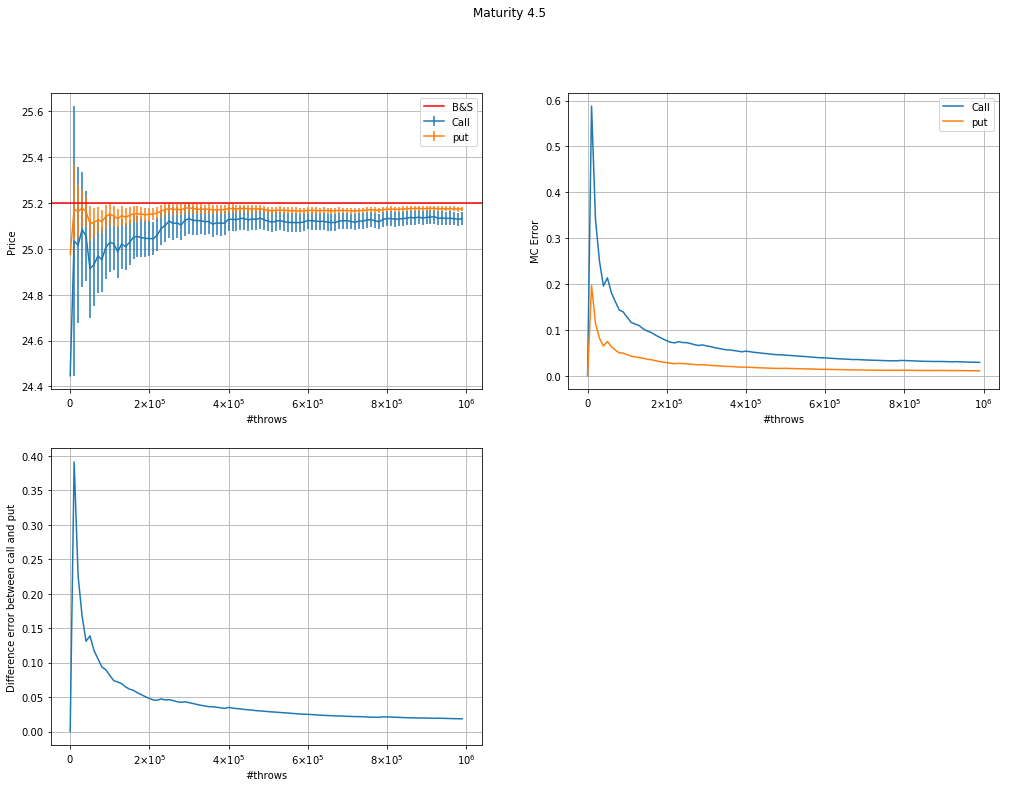

In [33]:
n = len(r1.T)-1
plt.figure(figsize=(17,12))
plt.suptitle("Maturity "+str(round(maturities[n],2)))
call_black = European_option_closed_form(orward=F(maturities), strike=K1[n], maturity=maturities, reference=t, volatility=volatility, zero_interest_rate=r, typo = kind)
plt.subplot(2,2,1)
plt.errorbar(x1,r1.T[n],yerr=e1.T[n],label="Call")
plt.errorbar(x2,r2.T[n],yerr=e2.T[n],label="put")
plt.axhline(y=call_black[n], color = 'red',linestyle='-',label = 'B&S')
plt.xlabel("#throws")
plt.ylabel("Price")
f = mticker.ScalarFormatter(useOffset=False, useMathText=True)
g = lambda x,pos : "${}$".format(f._formatSciNotation('%1.10e' % x))
plt.gca().xaxis.set_major_formatter(mticker.FuncFormatter(g))
plt.legend()
plt.grid(True)

plt.subplot(2,2,2)
plt.plot(x1,e1.T[n],label="Call")
plt.plot(x2,e2.T[n],label="put")
plt.legend()
plt.grid(True)
plt.xlabel("#throws")
f = mticker.ScalarFormatter(useOffset=False, useMathText=True)
g = lambda x,pos : "${}$".format(f._formatSciNotation('%1.10e' % x))
plt.gca().xaxis.set_major_formatter(mticker.FuncFormatter(g))
plt.ylabel("MC Error")

plt.subplot(2,2,3)
plt.plot(x1,abs(e1.T[n]-e2.T[n]))
plt.grid(True)
plt.ylabel("Difference error between call and put")
plt.xlabel("#throws")
f = mticker.ScalarFormatter(useOffset=False, useMathText=True)
g = lambda x,pos : "${}$".format(f._formatSciNotation('%1.10e' % x))
plt.gca().xaxis.set_major_formatter(mticker.FuncFormatter(g))

plt.show()

In [34]:
result1 ,errore_result1 = MC(option1)
result2 ,errore_result2 = MC(option2)

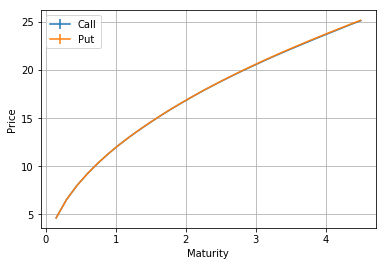

In [35]:
plt.errorbar(maturities,result1,yerr=errore_result1,label="Call")
plt.errorbar(maturities,result2,yerr=errore_result2,label="Put")
plt.legend()
plt.grid(True)
plt.xlabel("Maturity")
plt.ylabel("Price")
plt.show()

## OTHER RESULTS

### Result for a fixed strike K = 1 [$S_0$] in pricing therms

In [ ]:
K = spot_price
price_call = Vanilla_PayOff(St=S_t, strike = K, typo = kind)
result, result_err = MC(price_call)*D(maturities)
#np.savetxt("Results/European_call_maturity.txt",result)
#np.savetxt("Results/European_call_err_maturity.txt",result_err)

In [ ]:
#result = np.loadtxt("Results/European_call_maturity.txt")
#result_err = np.loadtxt("Results/European_call_err_maturity.txt")
plt.errorbar(maturities,result,yerr=result_err,label = 'Monte Carlo')
plt.plot(maturities,call_black, color = 'red',label = 'B&S')
plt.xlabel("Maturity")
plt.title("Strike = "+str(strike/spot_price)+" [$S_0$]")
plt.legend()
if kind==1:
    plt.ylabel('Call option price')
   # plt.savefig('Graphs/European_call_maturity.pdf')
elif kind==-1:
    plt.ylabel('Put option price')
  #  plt.savefig('Graphs/European_put_maturity.pdf')

plt.show()

### Result at fixed Maturity [T=4] in terms of price

In [ ]:
T = 4.0
fixings = np.array([0,T])
S_t = B_model.simulate(fixings=fixings, Nsim=1e6, seed=1)
k = np.arange(1,51)*(spot_price*0.25)
result = np.zeros(len(k))
result_err = np.zeros(len(k))
for i in range(len(k)):
    price_call = B_model.Vanilla_PayOff(St=S_t, strike = k[i], typo = kind)*discount_curve(fixings)
    r, r_err = MC(price_call)
    result[i] = r[1]
    result_err[i] = r_err[1]
#np.savetxt("Results/European_call_strike.txt",result)
#np.savetxt("Results/European_call_err_strike.txt",result_err)

In [ ]:
k = np.arange(1,51)*(spot_price*0.25)
T = 4.0
fixings = np.array([0,T])
#result = np.loadtxt("Results/European_call_strike.txt")
#result_err = np.loadtxt("Results/European_call_err_strike.txt")
call_black = European_closed_form(S=spot_price, K=k, T=fixings[1], r = zero_rate, q=0, sigma=volatility, typo = kind)
plt.errorbar(k/spot_price,result,yerr=result_err,label = 'Monte Carlo')
plt.plot(k/spot_price,call_black, color = 'red',label = 'B&S')
plt.xlabel("Strike [$S_0$]")
plt.title("Maturity = "+str(fixings[1]))
plt.xlim(0,5)
plt.legend()
if kind==1:
    plt.ylabel('Call option price')
   # plt.savefig('Graphs/European_call_strike.pdf')
elif kind==-1:
    plt.ylabel('Put option price')
    #plt.savefig('Graphs/European_put_strike.pdf')

plt.show()